## Notes

The equivariant neural network implementation is loosely based on [PointNet](https://arxiv.org/pdf/1612.00593.pdf). I only implemented the first 'standard transform layer', but could design a much more detailed one. Here is the [GitHub repo](https://github.com/fxia22/pointnet.pytorch/blob/f0c2430b0b1529e3f76fb5d6cd6ca14be763d975/pointnet/model.py#L11) to the code

## Hyperparameters
- Adam{"lr": 0.00001} / SELU() / max / SVI

## Comparison
- Amortized
    - PermNet: 14 sec / iter
- Not Amortized
    - PermNet: 15 sec / iter

## BUGS
- cluster degeneracy w/ pointnet (one cluster makes up the majority of the proportion vector)
    - [DEEP UNSUPERVISED CLUSTERING WITH GAUSSIAN MIXTURE VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1611.02648.pdf)


## Resources
- [Tutorial on to_event and .expand()](https://bochang.me/blog/posts/pytorch-distributions/)
- [Event, Batch, Sample shapes](https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/)
- [Debugging Neural Networks](https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn)

### Import Packages

In [1]:
from pointnet import PointNet
from permnet import PermNet

import numpy as np
import time

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, AdamW
from pyro.nn import PyroModule

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

from tabulate import tabulate

### Generate Data

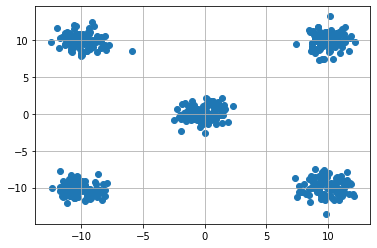

In [2]:
N = 500  # number of data points
M = 2  # number of features
T = 5  # Fixed number of components.

cov = np.identity(M)  # covariance matrix is just the identity for now

# generate data
clust1 = np.random.multivariate_normal(np.zeros(M), cov, 100)
clust2 = np.random.multivariate_normal(np.ones(M)*10, cov, 100)
clust3 = np.random.multivariate_normal(np.ones(M)*-10, cov, 100)
clust4 = np.random.multivariate_normal([10, -10], cov, 100)
clust5 = np.random.multivariate_normal([-10, 10], cov, 100)
data = np.concatenate((clust1, clust2, clust3, clust4, clust5))

plt.scatter(data[:,0], data[:,1])
plt.grid()

data = torch.from_numpy(data).float()  # convert numpy to torch

### Pyro

In [3]:
def model(data, step):
    # global variables
    alpha = torch.ones(T)
    weights = pyro.sample('weights', Dirichlet(alpha))
    
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(torch.zeros(M), torch.eye(M)))

    # local variables
    with pyro.plate('data', N):
        assignment = pyro.sample('assignments', Categorical(weights))
        pyro.sample('obs', MultivariateNormal(locs[assignment], torch.eye(M)), obs=data)
        
def guide(data, step):
    
    # train nn if doing offline training
    if not amortize:
        pyro.module('alpha_mlp', alpha_mlp)
        pyro.module('tau_mlp', tau_mlp)
    
    if use_gpu: 
        data = data.cuda()
    
    # sample mixture components mu
    tau = tau_mlp(data.float())
    tau = tau.view(T,M)  # reshape tensor
    
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(tau, torch.eye(M)))
    
    # sample cluster assignments
    alpha = alpha_mlp(data.float()) # returns a vector of length T
    weights = pyro.sample('weights', Dirichlet(alpha))  # vector of length T
    with pyro.plate('data', N):
        assignments = pyro.sample('assignments', Categorical(weights))
    
    if step % log_iter == 0:
        
        print('='*10, 'Iteration {}'.format(step), '='*10)
        weight_data = [weights[0][i] for i in range(len(weights[0]))]
        weight_data.insert(0, 'props')

        mu1_data = [locs[i,0] for i in range(locs.shape[0])]
        mu1_data.insert(0, 'mu1')

        mu2_data = [locs[i,1] for i in range(locs.shape[0])]
        mu2_data.insert(0, 'mu2')
        
        data = [weight_data, mu1_data, mu2_data]
        
        print(tabulate(data, headers=['', 'clust1', 'clust2', 'clust3', 'clust4', 'clust5']))

### Initialization

In [4]:
mlp_type = 'permnet'
amortize = False


if mlp_type == 'pointnet':
    alpha_mlp = PointNet(in_ch=M, output_size=T).float() 
    tau_mlp = PointNet(in_ch=M, output_size=T*M, softmax=False).float()
if mlp_type == 'permnet':
    alpha_mlp = PermNet(in_ch=M, hidden=256, output_size=T).float()
    tau_mlp = PermNet(in_ch=M, hidden=256, output_size=T*M).float()

if amortize:
    saved_alpha_mlp = torch.load('saved_models/{}/vanilla_alpha_mlp.pth'.format(mlp_type))
    saved_tau_mlp = torch.load('saved_models/{}/vanilla_tau_mlp.pth'.format(mlp_type))
    
    alpha_mlp.load_state_dict(saved_alpha_mlp['model_state_dict'])
    tau_mlp.load_state_dict(saved_tau_mlp['model_state_dict'])
    

adam_params = {"lr": 0.001}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# use gpu
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('using GPU!')
    alpha_mlp = alpha_mlp.cuda()
    tau_mlp = tau_mlp.cuda()
else:
    print('not using GPU!')

not using GPU!


/home/kyang/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


### Training

In [5]:
dry = False
log_iter = 50

n_steps = 500
start = time.time()
for step in range(n_steps):
    svi.step(data, step)
    pyro.get_param_store()
    if step % log_iter == 0:
        end = time.time()
        print('took', end-start, 'seconds')
        start = time.time()
        
    if not dry:
        torch.save({'model_state_dict': alpha_mlp.state_dict(),
                    'steps': n_steps
                   }, 'saved_models/{}/vanilla_alpha_mlp.pth'.format(mlp_type))

        torch.save({'model_state_dict': tau_mlp.state_dict(),
                    'steps': n_steps
                   }, 'saved_models/{}/vanilla_tau_mlp.pth'.format(mlp_type))

========== Iteration 0 ==========
       clust1                                                                         clust2     clust3     clust4    clust5
-----  ---------------------------------------------------------------------------  --------  ---------  ---------  --------
props  tensor([0.2970, 0.2482, 0.1224, 0.2969, 0.0354], grad_fn=<SelectBackward0>)
mu1    0.6024090051651001                                                            1.85148  -0.449978   3.62224    2.61491
mu2    3.220020055770874                                                             2.32618   1.94311   -0.471283   1.68917
took 13.208665132522583 seconds
========== Iteration 50 ==========
       clust1                                                                         clust2     clust3    clust4    clust5
-----  ---------------------------------------------------------------------------  --------  ---------  --------  --------
props  tensor([0.1630, 0.3130, 0.3555, 0.0799, 0.0887], grad_fn=<Sel

KeyboardInterrupt: 